In [1]:
# Open CV

In [24]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import display, Image, clear_output
import os
import cv_helper
from filter_to_motion import *

# import pixellib
# from pixellib.semantic import semantic_segmentation
import torch
import torchvision
from PIL import Image

In [2]:
class remove_background:
    def __init__(self, base_filename, in_fps=30):
        self.base_filename = base_filename
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        self.state = FrameState(0, 0)

    def destroy(self):
        pass

    def frame(self, idx, original_frame):
        self.state.idx = idx

        # PERF: Processing at 1/4 size boosts FPS by TK%
        in_frame = shrink_image_half(original_frame)

        # PERF: Motion Mask sampled frames
        motion_mask = to_motion_mask_fast(self.state, in_frame)

        # skip frames with no motion
        if is_frame_black(motion_mask):
            return

        # PERF - show_debug_window at on sampled frames
        if idx % self.debug_window_refresh_rate == 0:
            debug_frame = create_analyze_debug_frame(in_frame, motion_mask)
            burn_in_debug_info(debug_frame, idx, self.in_fps)
            masked_input = cv2.bitwise_and(in_frame, in_frame, mask=motion_mask)
            cv_helper.display_jupyter(masked_input)

In [3]:
input_video_path = "~/downloads/igor-magic.mp4"
ic(input_video_path)

ic| input_video_path: '~/downloads/igor-magic.mp4'


'~/downloads/igor-magic.mp4'

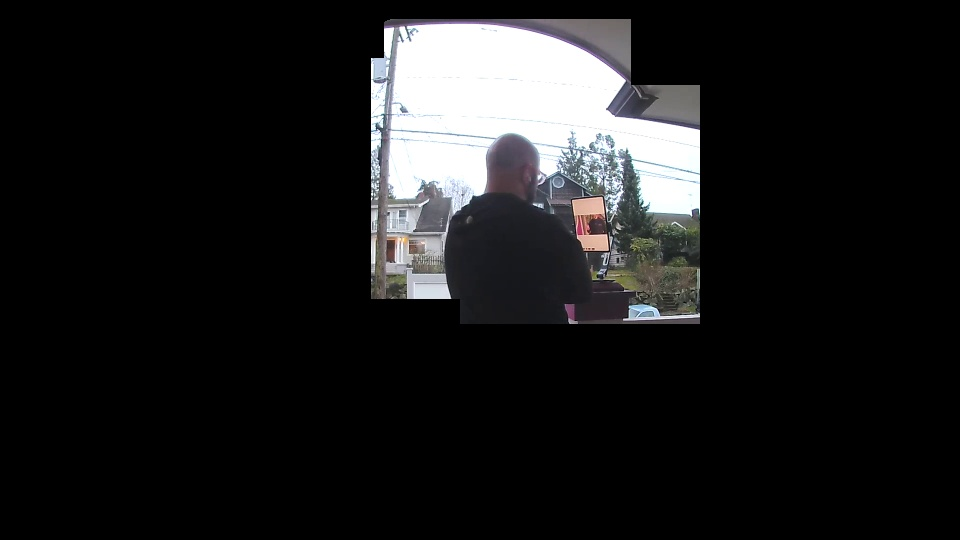

ic| int(fps.fps()): 86, int(fps.elapsed()): 11


In [4]:
rb = remove_background(input_video_path, 30)
cv_helper.process_video(cv_helper.cv2_video(input_video_path), rb)

# Pixel Lab - not great, a random incohrent set of APIs, but setup for nice demos

In [5]:
# segment_frame = semantic_segmentation()
# segment_frame.load_ade20k_model(os.path.expanduser("~/downloads/deeplabv3_xception65_ade20k.h5"))

In [6]:
class segment:
    def __init__(self, segmenter, in_fps=30):
        self.segmenter = segmenter  # expensive to initate, cache it.
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        pass

    def destroy(self):
        pass

    def frame(self, idx, frame):
        if idx % self.in_fps * 5:
            ret, img = self.segmenter.segmentFrameAsAde20k(frame, overlay=True)
            cv_helper.display_jupyter(img)
            ic(ret.keys())
            ic(ret["class_ids"])
            ic(len(ret["masks"]))
            ic(len(ret["masks"][0]))
            ic(len(ret["masks"][1]))
            ic(len(ret["masks"][2]))
            ic(ret["masks"][14])

In [7]:
# sf = segment(segment_frame,30)
# cv_helper.process_video(cv_helper.cv2_video(input_video_path), sf)

## Using YoLo v5

In [53]:
from utils.plots import Annotator, colors


class YoloDetector:
    def __init__(self, in_fps=30):
        self.yolo = torch.hub.load(
            "ultralytics/yolov5", "yolov5s"
        )  # or yolov5m, yolov5l, yolov5x, custom
        self.in_fps = in_fps

    def create(self, input_video):
        pass

    def destroy(self):
        pass

    def frame(self, idx, frame):
        # pretty expensive, only do every 10 seconds
        if idx % (self.in_fps * 1) != 0:
            return

        # Inference
        results = self.yolo(frame)
        predictions = results.pred[0]

        # PyTorch uses PIL Format
        # I wonder if I can skip some of these switches
        # You may need to convert the color.
        img_pil = np.ascontiguousarray(
            Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        )

        annotator = Annotator((img_pil))
        for *box, confidence, cls in predictions:
            # ic(cls, confidence, results.names[int(cls)])
            label = f"{results.names[int(cls)]} {confidence:.2f}"
            annotator.box_label(box, label, color=colors(cls))

        # For reversing the operation:
        im_np = np.asarray(annotator.im)
        cv_helper.display_jupyter(im_np)

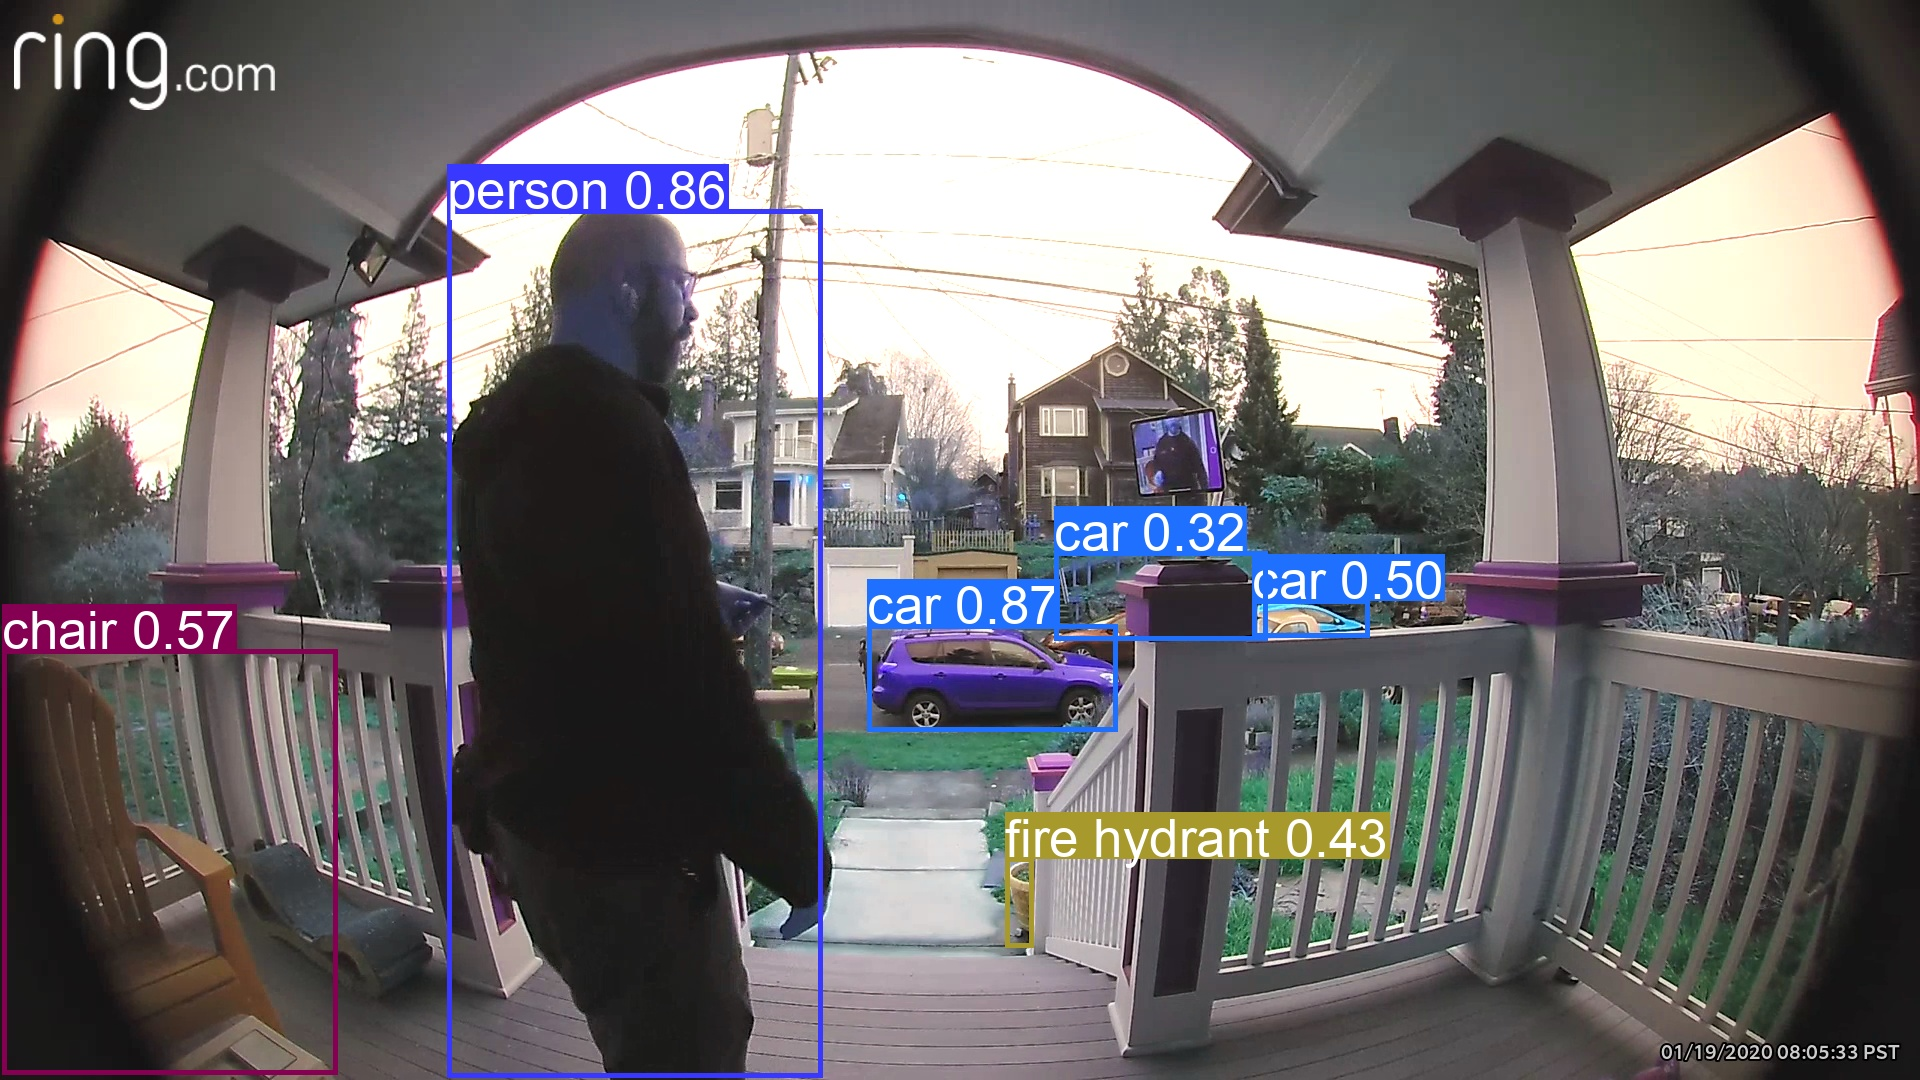

In [ ]:
# Images
# img = os.path.expanduser('~/downloads/amelia-face.jpg')
yolo = YoloDetector()
cv_helper.process_video(cv_helper.cv2_video(input_video_path), yolo)

In [34]:
results.save()

Saved 1 image to runs/detect/exp2


ic| pred: tensor([[0.00000e+00, 1.52872e+02, 1.32618e+03, 1.79822e+03, 5.18494e-01, 0.00000e+00]])
ic| results.pred[0]: tensor([[0.00000e+00, 1.52872e+02, 1.32618e+03, 1.79822e+03, 5.18494e-01, 0.00000e+00]])
ic| box: [tensor(0.), tensor(152.87161), tensor(1326.17896), tensor(1798.21509)]
ic| confidence: tensor(0.51849)
ic| cls: tensor(0.)
ic| results.names[int(cls)]: 'person'


In [12]:
ic(results.tolist())

ic| results.tolist(): [<models.common.Detections object at 0x7f7663d6a9a0>]


In [19]:
import utils.plot

ModuleNotFoundError: No module named 'utils.plot'

In [20]:
utils.plots

NameError: name 'utils' is not defined

In [21]:
import utils.plots

In [23]:
utils.plots.Annotator

utils.plots.Annotator